Part of https://github.com/htdt/cartpole-solved

**Warning!** This is not traditional way of training DQN with RNN, this is work in progress. Consider [R2D2](https://openreview.net/forum?id=r1lyTjAqYX).

In [0]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html
!pip install -q gym ipdb

In [0]:
from collections import deque
import gym, random, math, ipdb
from tqdm import trange
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

gym.logger.set_level(40)

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
N_STEP = 3
GAMMA = .99
LR = 1e-3

In [0]:
class DQN(nn.Module):
  input_dim = 4
  output_dim = 2
  hidden = 64

  def __init__(self):
    super(DQN, self).__init__()
    self.features = nn.Sequential(
      nn.Linear(self.input_dim, self.hidden),
      nn.ReLU(),
      nn.Linear(self.hidden, self.hidden),
      nn.ReLU())
    self.rnn = nn.GRUCell(self.hidden, self.hidden)
    self.adv = nn.Linear(self.hidden, self.output_dim)
    self.val = nn.Linear(self.hidden, 1)

  def forward(self, x, hx):
    x = self.features(x)
    x = hx = self.rnn(x, hx)
    adv = self.adv(x)
    val = self.val(x)
    return val + adv - adv.mean(1, keepdim=True), hx

In [0]:
class Agent:
  output_dim = 2
  batch_size = 32

  def __init__(self):
    self.online_net = DQN()
    self.online_net.train()

    self.target_net = DQN()
    self.update_target_net()
    for param in self.target_net.parameters(): param.requires_grad = False

    self.optimiser = optim.Adam(self.online_net.parameters(), lr=LR)

  def act(self, state):
    x = torch.FloatTensor(state[0]).unsqueeze(0)
    hx = state[1]
    with torch.no_grad():
      q, hx = self.online_net(x, hx)
      return q.argmax(1).item(), hx

  def act_e_greedy(self, state, epsilon=0.01):
    if random.random() < epsilon:
      return random.randrange(self.output_dim), state[1]
    else:
      return self.act(state)

  def train_iter(self, buffer):
    state, hidden, action, reward, next_state, next_hidden, terminal = buffer.sample(self.batch_size)
    
    q_value = self.online_net(state, hidden)[0][range(self.batch_size), action]
    with torch.no_grad():
      next_state_action = self.online_net(next_state, next_hidden)[0].max(1)[1] # online_net to get action for next_state
      next_qv = self.target_net(next_state, next_hidden)[0][range(self.batch_size), next_state_action] # target_net to get Q
      target_qv = reward + (GAMMA ** N_STEP) * (1 - terminal) * next_qv
    
    loss = (q_value - target_qv).pow(2).mean()

    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()
    return loss.item()

  def update_target_net(self):
    self.target_net.load_state_dict(self.online_net.state_dict())

In [0]:
H0 = torch.zeros(1, 64)

class ReplayBuffer():
  def __init__(self, capacity):
    self.capacity = capacity
    self._buffer = deque(maxlen=self.capacity)
  
  def append(self, state, hidden, action, reward, terminal):
    self._state.append(state)
    self._hidden.append(hidden)

    step = len(self._state) - 1
    self._reward += reward * (GAMMA ** step)
    
    if step == N_STEP or terminal: # terminal step is crucial, append it anyway
      self._buffer.append((self._state[0], self._hidden[0], action, self._reward,\
                           self._state[-1], self._hidden[-1], terminal))
      self._reward = 0
      self._state = self._state[-1:]
      self._hidden = self._hidden[-1:]

  def sample(self, batch_size):
    s, h, a, r, ns, nh, t = zip(*random.sample(self._buffer, batch_size))
    f, l = torch.FloatTensor, torch.LongTensor
    return f(s), torch.cat(h), l(a), f(r), f(ns), torch.cat(nh), f(t)

  def new_episode(self, s):
    self._reward = 0
    self._state = [s]
    self._hidden = [H0]

  def cur_state(self):
    return self._state[-1], self._hidden[-1]

  def __len__(self):
    return len(self._buffer)

100%|██████████| 10000/10000 [01:32<00:00, 108.18it/s]


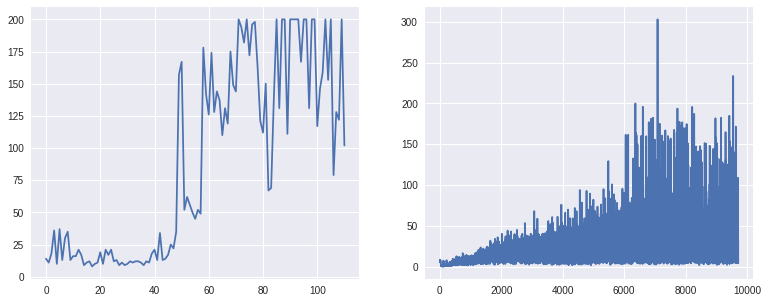

In [8]:
buffer = ReplayBuffer(5000)
env = gym.make("CartPole-v0")
agent = Agent()

rewards, loss = [], []
episode_reward = 0
state = env.reset()
buffer.new_episode(state)

for i in trange(10000):
  eps = .01 + .99 * math.exp(-i / 500) # close to .01 at 3500
  action, hx = agent.act_e_greedy(buffer.cur_state(), eps)
  state, reward, terminal, _ = env.step(action)
  buffer.append(state, hx, action, reward, terminal)
  episode_reward += reward
  
  if terminal:
    state = env.reset()
    buffer.new_episode(state)
    rewards.append(episode_reward)
    episode_reward = 0

  if len(buffer) > 100:
    loss.append(agent.train_iter(buffer))
   
  if len(buffer) > 100 and i % 100 == 0:
    agent.update_target_net()

plt.figure(figsize=(20,5))
plt.subplot(131)
plt.plot(rewards)
plt.subplot(132)
plt.plot(loss)